In [2]:
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import sys
from tqdm import tqdm
sys.path.insert(0, os.getcwd() + '/code')
from viz import *
from helper_functions import * 
from multiprocessing import Pool
from scipy.signal import argrelextrema

In [3]:
df_game = pd.read_csv("data/games.csv")
df_tracking = pd.read_csv("data/week1.csv")
df_play = pd.read_csv("data/plays.csv")
df_players = pd.read_csv("data/players.csv")
df_pffScoutingData = pd.read_csv("data/pffScoutingData.csv")

df_tracking = pd.read_csv(f"data/week{1}.csv")
df_area_t = pd.read_csv(f"data/area/area_t.csv").drop(columns=['Unnamed: 0','Unnamed: 0.1'])
df_area_features = pd.read_csv(f"data/area_features/Area_features.csv").drop(columns=['Unnamed: 0'])
#playIds = df_area.playId.unique()

In [4]:
print(df_area_t.head())

   frameId      Area  playId      gameId
0        1  22.31990      97  2021090900
1        2  22.16275      97  2021090900
2        3  22.16015      97  2021090900
3        4  22.45335      97  2021090900
4        5  22.72785      97  2021090900


In [8]:
print(df_area_features.head())

   playId      gameId  event  te         Ae  tc         Ac  tsnap
0      97  2021090900  hurry  35  12.237518  32  15.013121      5
1     137  2021090900   pass  26  16.305513  16  26.760950      6
2     187  2021090900   pass  23  18.312900  15  25.935250      5
3     282  2021090900   pass  33  29.901092  30  36.001815      5
4     349  2021090900  hurry  27  14.784734  13  24.298700      6


# Limit area for scramble occurence

In [9]:
print(f'Total n° of plays : {len(df_play)}')
scramble_mask = "(event == 'scramble' | event == 'sack')"
scramble_plays = df_area_features.query(scramble_mask)
scramble_plays = pd.merge(scramble_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of scramble or sack plays : {len(scramble_plays)}')
scramble_plays_wo_PA = scramble_plays[scramble_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(scramble_plays_wo_PA)}')
print(scramble_plays_wo_PA.head())


Total n° of plays : 8557
n° of scramble or sack plays : 1815
n° of scramble or sack plays w/o play action : 1139
   playId      gameId     event  te         Ae  tc        Ac  tsnap  \
2     947  2021090900  scramble  32   6.471160  13  23.76425      5   
6    2032  2021090900  scramble  33  13.483074  28  17.20230      5   
7    2279  2021090900  scramble  30   8.196493  12  21.51920      5   
8    2298  2021090900  scramble  36   4.706347  18  27.39720      5   
9    2330  2021090900  scramble  37  23.306400  17  24.66465      5   

                                     playDescription  quarter  ...  \
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
6  (2:45) (No Huddle, Shotgun) T.Brady pass deep ...        2  ...   
7  (1:11) (Shotgun) D.Prescott sacked at TB 33 fo...        2  ...   
8  (:35) (No Huddle, Shotgun) D.Prescott scramble...        2  ...   
9  (:28) (Shotgun) D.Prescott scrambles left end ...        2  ...   

   foulNFLId3  absoluteYardlineNumber o

In [10]:
scramble_plays["Acrit"] = np.nan
for scramble_id in tqdm(scramble_plays.index):

    scramble_play = scramble_plays.loc[scramble_id].playId
    scramble_game = scramble_plays.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays.head())
print(scramble_plays.Acrit.mean())
print(scramble_plays.Acrit.std())


100%|██████████| 1815/1815 [00:02<00:00, 899.52it/s]

   playId      gameId     event  te         Ae  tc         Ac  tsnap  \
0     735  2021090900  scramble  35  49.791600  34  49.794450      5   
1     764  2021090900  scramble  22  24.175115  19  26.277012      6   
2     947  2021090900  scramble  32   6.471160  13  23.764250      5   
3    1312  2021090900  scramble  19  28.861884  18  27.105112      5   
4    1425  2021090900  scramble  25  32.751879  19  42.508076      6   

                                     playDescription  quarter  ...  \
0  (2:45) (Shotgun) D.Prescott pass short right t...        1  ...   
1  (2:22) (No Huddle) D.Prescott pass short right...        1  ...   
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
3  (9:53) T.Brady pass short right to R.Gronkowsk...        2  ...   
4  (9:04) D.Prescott pass short right to B.Jarwin...        2  ...   

   absoluteYardlineNumber  offenseFormation        personnelO defendersInBox  \
0                    47.0           SHOTGUN  1 RB, 1 TE, 3 WR     

In [11]:
scramble_plays_wo_PA["Acrit"] = np.nan
print(len(scramble_plays_wo_PA))
for scramble_id in tqdm(scramble_plays_wo_PA.index):

    scramble_play = scramble_plays_wo_PA.loc[scramble_id].playId
    scramble_game = scramble_plays_wo_PA.loc[scramble_id].gameId

    selected_area_features_df = df_area_features[(df_area_features .playId==scramble_play)&(df_area_features.gameId==scramble_game)].copy()
    selected_area_t_df = df_area_t[(df_area_t.playId==scramble_play)&(df_area_t.gameId==scramble_game)].copy()

    Acrit = np.min(selected_area_t_df[selected_area_t_df.frameId <= int(selected_area_features_df.te)].Area)
    scramble_plays_wo_PA.loc[scramble_id,"Acrit"] = Acrit
print(scramble_plays_wo_PA.head())
print(scramble_plays_wo_PA.Acrit.mean())
print(scramble_plays_wo_PA.Acrit.std())

/tmp/ipykernel_42479/56136737.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



1139


100%|██████████| 1139/1139 [00:01<00:00, 878.36it/s]

   playId      gameId     event  te         Ae  tc        Ac  tsnap  \
2     947  2021090900  scramble  32   6.471160  13  23.76425      5   
6    2032  2021090900  scramble  33  13.483074  28  17.20230      5   
7    2279  2021090900  scramble  30   8.196493  12  21.51920      5   
8    2298  2021090900  scramble  36   4.706347  18  27.39720      5   
9    2330  2021090900  scramble  37  23.306400  17  24.66465      5   

                                     playDescription  quarter  ...  \
2  (:05) (Shotgun) T.Brady pass incomplete short ...        1  ...   
6  (2:45) (No Huddle, Shotgun) T.Brady pass deep ...        2  ...   
7  (1:11) (Shotgun) D.Prescott sacked at TB 33 fo...        2  ...   
8  (:35) (No Huddle, Shotgun) D.Prescott scramble...        2  ...   
9  (:28) (Shotgun) D.Prescott scrambles left end ...        2  ...   

   absoluteYardlineNumber  offenseFormation        personnelO defendersInBox  \
2                    70.0           SHOTGUN  1 RB, 1 TE, 3 WR           

In [13]:
print(f'Total n° of plays : {len(df_play)}')
pass_mask = "event == 'pass'"
pass_plays = df_area_features.query(pass_mask)
pass_plays = pd.merge(pass_plays,df_play,how="left",on = ["playId","gameId"])
print(f'n° of pass plays : {len(pass_plays)}')
pass_plays_wo_PA = pass_plays[pass_plays.pff_playAction == 0]
print(f'n° of scramble or sack plays w/o play action : {len(pass_plays_wo_PA)}')
print(pass_plays_wo_PA.head())

Total n° of plays : 8557
n° of pass plays : 4589
n° of scramble or sack plays w/o play action : 3721
   playId      gameId event  te         Ae  tc        Ac  tsnap  \
0     137  2021090900  pass  26  16.305513  16  26.76095      6   
1     187  2021090900  pass  23  18.312900  15  25.93525      5   
3     410  2021090900  pass  17  15.032565  11  21.95730      5   
4     434  2021090900  pass  18  22.734450  13  25.76265      5   
5     456  2021090900  pass  26  17.199900  13  26.91230      5   

                                     playDescription  quarter  ...  \
0  (13:18) (Shotgun) D.Prescott pass deep left to...        1  ...   
1  (12:23) (Shotgun) D.Prescott pass short middle...        1  ...   
3  (8:53) (Shotgun) T.Brady pass short middle to ...        1  ...   
4  (8:24) (No Huddle, Shotgun) T.Brady pass incom...        1  ...   
5  (8:20) (Shotgun) T.Brady pass deep middle to R...        1  ...   

   foulNFLId3  absoluteYardlineNumber offenseFormation        personnelO  \

In [14]:
print(pass_plays.Ae.mean())
print(pass_plays.Ae.std())

print(pass_plays_wo_PA.Ae.mean())
print(pass_plays_wo_PA.Ae.std())

20.094474516286798
11.333555071494743
17.625335286796545
7.369198090780504


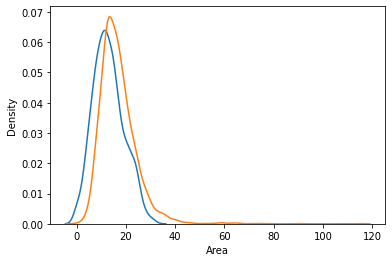

In [17]:
import seaborn as sns
sns.kdeplot(scramble_plays_wo_PA.Acrit)
sns.kdeplot(pass_plays_wo_PA.Ae)
plt.xlabel("Area")
plt.show()

In [23]:
from scipy.stats import normaltest
from scipy.stats import ttest_ind
test = normaltest(scramble_plays_wo_PA.Acrit)
print(f"p-value for normality test Acrit on scramble plays : {test.pvalue}")
test = normaltest(pass_plays_wo_PA.Ae)
print(f"p-value for normality test Ae on pass plays : {test.pvalue}")

test = ttest_ind(scramble_plays_wo_PA.Acrit, pass_plays_wo_PA.Ae)
print(f"Statistic for T-test : {test.statistic}")
print(f"p-value for T-test : {test.pvalue}")

p-value for normality test Acrit on scramble plays : 7.473619333378096e-07
p-value for normality test Ae on pass plays : 0.0
Statistic for T-test : -16.07306857570401
p-value for T-test : 7.841961880885834e-57


# Is characteristic area characteristic of the teams passing game?

In [48]:
print(f'Total n° of plays : {len(df_play)}')
plays_w_features = pd.merge(df_area_features,df_play,how="left",on = ["playId","gameId"])
print(f'n° of plays in study: {len(plays_w_features)}')
plays_w_features_wo_PA = plays_w_features[plays_w_features.pff_playAction == 0]
print(f'n° of plays w/o play action : {len(plays_w_features_wo_PA)}')
print(plays_w_features_wo_PA.columns)



Total n° of plays : 8557
n° of plays in study: 7574
n° of plays w/o play action : 5772
Index(['playId', 'gameId', 'event', 'te', 'Ae', 'tc', 'Ac', 'tsnap',
       'playDescription', 'quarter', 'down', 'yardsToGo', 'possessionTeam',
       'defensiveTeam', 'yardlineSide', 'yardlineNumber', 'gameClock',
       'preSnapHomeScore', 'preSnapVisitorScore', 'passResult', 'penaltyYards',
       'prePenaltyPlayResult', 'playResult', 'foulName1', 'foulNFLId1',
       'foulName2', 'foulNFLId2', 'foulName3', 'foulNFLId3',
       'absoluteYardlineNumber', 'offenseFormation', 'personnelO',
       'defendersInBox', 'personnelD', 'dropBackType', 'pff_playAction',
       'pff_passCoverage', 'pff_passCoverageType'],
      dtype='object')


In [36]:
means_df = plays_w_features_wo_PA.groupby("possessionTeam").mean().reset_index()
means_df

/tmp/ipykernel_42479/516944232.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



,possessionTeam,playId,gameId,te,Ae,tc,Ac,tsnap,quarter,down,...,preSnapVisitorScore,penaltyYards,prePenaltyPlayResult,playResult,foulNFLId1,foulNFLId2,foulNFLId3,absoluteYardlineNumber,defendersInBox,pff_playAction
0,ARI,1962.537736,2.021098e+09,31.481132,25.259211,21.570755,34.330005,5.245283,2.391509,1.985849,...,13.410377,5.352941,7.433962,7.886792,44732.705882,NaN,NaN,59.273585,5.816038,0.330189
1,ATL,2089.052239,2.021097e+09,27.555970,19.032346,18.167910,27.518397,5.171642,2.492537,2.007463,...,9.891791,6.814815,5.626866,6.093284,45710.115385,NaN,NaN,62.406716,6.152985,0.287313
2,BAL,2221.799163,2.021098e+09,33.523013,21.468977,22.682008,31.891341,5.656904,2.707113,1.870293,...,14.422594,-3.500000,6.933054,6.702929,42711.666667,NaN,NaN,58.112971,5.887029,0.301255
3,BUF,2080.529915,2.021096e+09,30.735043,23.014902,20.329060,33.337592,6.452991,2.470085,1.850427,...,9.252137,0.826087,7.012821,6.803419,44777.136364,44759.333333,NaN,58.200855,5.897436,0.243590
4,CAR,2233.130282,2.021098e+09,30.457746,18.017040,19.961268,29.333340,5.288732,2.640845,2.035211,...,7.901408,3.041667,5.911972,5.964789,46672.875000,NaN,NaN,60.820423,6.154930,0.197183
5,CHI,2004.775229,2.021098e+09,29.486239,19.863427,18.568807,28.538171,5.229358,2.518349,2.041284,...,5.949541,8.947368,4.949541,5.215596,45119.736842,46146.000000,NaN,58.348624,5.889908,0.238532
6,CIN,1897.099585,2.021098e+09,28.668050,18.711046,18.161826,25.765420,5.207469,2.452282,2.000000,...,10.099585,4.333333,7.896266,7.917012,45452.380952,43694.000000,NaN,59.896266,5.950207,0.203320
7,CLE,1882.440529,2.021098e+09,30.546256,24.931806,21.220264,33.604029,5.110132,2.352423,2.022026,...,10.563877,-0.307692,5.691630,5.585903,47658.538462,53679.000000,NaN,57.603524,6.189427,0.277533
8,DAL,2142.679654,2.021097e+09,28.229437,19.933644,18.640693,28.137538,6.354978,2.471861,1.969697,...,10.753247,0.862069,7.961039,7.402597,44087.931034,47302.333333,NaN,60.476190,6.294372,0.246753
9,DEN,2137.655870,2.021098e+09,30.453441,18.172181,19.210526,25.851462,5.275304,2.716599,1.967611,...,10.133603,6.285714,6.178138,6.497976,47134.666667,NaN,NaN,63.955285,6.134146,0.259109


In [37]:
fig_bar_plot_team(means_df, 'Ac', 'possessionTeam', y_legend = "Mean max. pocket area", ascending_metric = False, imagette_size = 2)

In [43]:
formations_df = plays_w_features_wo_PA.groupby("offenseFormation").mean().reset_index()

/tmp/ipykernel_42479/3416141354.py:1: FutureWarning:

The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.



In [49]:
for formation in plays_w_features_wo_PA.offenseFormation.unique():
    print(formation, len(plays_w_features_wo_PA[plays_w_features_wo_PA.offenseFormation == formation]))

SHOTGUN 4278
EMPTY 1218
SINGLEBACK 163
PISTOL 58
I_FORM 47
nan 0
JUMBO 3
WILDCAT 1
